In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import pandas as pd
import numpy as np
from itertools import cycle
from fastai.vision import *
from fastai.metrics import *

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [5]:
train_csv = Path('/home/amey/LTTS/data/train-u0.csv')
valid_csv = Path('/home/amey/LTTS/data/valid.csv')

ALL_LBLS = ['No Finding',
            'Cardiomegaly',
            'Edema',
            'Consolidation',
            'Atelectasis',
            'Pleural Effusion',
            'Enlarged Cardiomediastinum',
            'Lung Opacity',
            'Lung Lesion',
            'Pneumonia',
            'Pneumothorax',
            'Pleural Other',
            'Fracture',
            'Support Devices']

EVAL_LBLS = ['Cardiomegaly',
             'Edema',
             'Consolidation',
             'Atelectasis',
             'Pleural Effusion',]

BS = 32
IMG_SZ = 224
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])
GPU_IDS = [7]
torch.cuda.set_device(7)

EXP = 'fastai-vgg-224-u0'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

In [6]:
data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=valid_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

data

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
No Finding;Support Devices,Lung Opacity;Fracture,Lung Opacity;Fracture,Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Atelectasis;Lung Opacity;Support Devices,No Finding,Cardiomegaly;Enlarged Cardiomediastinum,Edema;Consolidation;Atelectasis;Pleural Effusion;Enlarged Cardiomediastinum;Lung Opacity,Lung Opacity;Support Devices
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None

In [ ]:
# print(data.train_ds)
# print(data.valid_ds)
doc(DataBunch.create)

In [7]:
from sklearn.metrics import roc_curve, auc

class AUC(Callback):

    def __init__(self, num_cl=14, pick='micro', plot_auc=False, plot_title=EXP+' - validation AUC', plot_path=RES_DIR+'valid_ROC_AUC.png'):
        self.id_to_class = {
            0: 'No Finding',
            1: 'Cardiomegaly',
            2: 'Edema',
            3: 'Consolidation',
            4: 'Atelectasis',
            5: 'Pleural Effusion',
            6: 'Enlarged Cardiomediastinum',
            7: 'Lung Opacity',
            8: 'Lung Lesion',
            9: 'Pneumonia',
            10: 'Pneumothorax',
            11: 'Pleural Other',
            12: 'Fracture',
            13: 'Support Devices',
            'micro': 'micro',
            'macro': 'macro',
        }
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        self.plot_path = plot_path
        self.plot_title = plot_title
        self.plot_auc = plot_auc
        
    
    def on_epoch_begin(self, **kwargs):
        self.outputs, self.targets = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.outputs.append(last_output)
        self.targets.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        self.outputs = torch.sigmoid(torch.cat(self.outputs)).cpu().detach().numpy()
        self.targets = torch.cat(self.targets).cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        self.targets, self.outputs = self.targets[:,1:6], self.outputs[:,1:6]
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,6)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(1,6):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        if self.plot_auc:
            # Plot all ROC curves
            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro (auc- {0:0.2f})'.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='macro (auc- {0:0.2f})'.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            colors = cycle(['blue', 'green', 'red', 'cyan', 'yellow', 'magenta', 'black'])
            for i, color in zip(range(12), colors):
                if roc_auc[self.id_to_class[i]] > 0:
                    plt.plot(fpr[i], tpr[i], color=color, lw=1,
                         label='{0} (auc- {1:0.2f})'.format(self.id_to_class[i], roc_auc[self.id_to_class[i]]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('{}'.format(self.plot_title))
            plt.legend(loc="lower right")
            plt.savefig(self.plot_path)
            print('roc-auc curve saved to {}'.format(self.plot_path))
        
        return add_metrics(last_metrics, roc_auc[self.id_to_class[self.pick]])

acc_02 = partial(accuracy_thresh, thresh=0.4)

In [8]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')])
# learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/amey/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:15<00:00, 37.1MB/s] 


epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


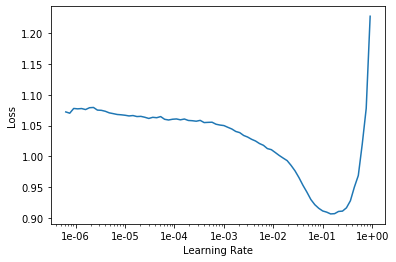

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.292663,0.383679,0.854090,0.825301,0.869724,0.892959,0.819805,0.920279,0.825090,32:00
1,0.274887,0.383421,0.858364,0.811924,0.909230,0.915272,0.784253,0.937081,0.838742,30:37


/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc-auc curve saved to results/fastai-vgg-224-u0/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-vgg-224-u0/valid_ROC_AUC.png


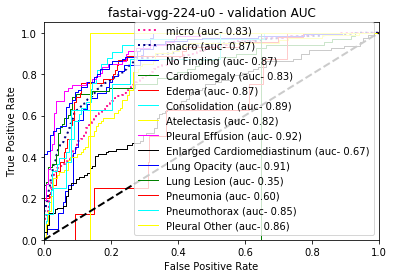

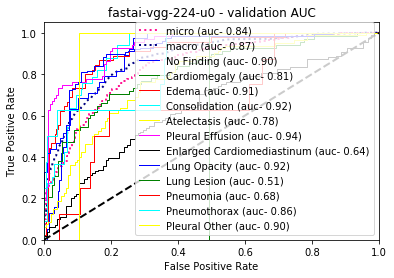

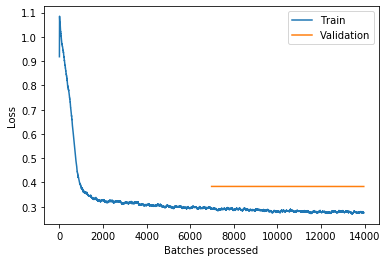

In [10]:
learn.unfreeze()
learn.fit_one_cycle(2)
learn.recorder.plot_losses()
learn.save(EXP+'-stage-1')

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


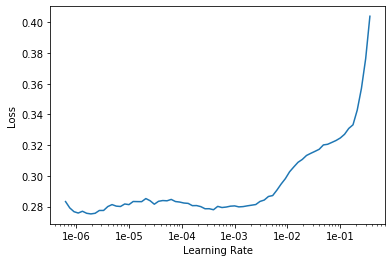

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.269494,0.382385,0.858669,0.785790,0.910053,0.904417,0.775244,0.933685,0.830212,30:47
1,0.274113,0.380311,0.863553,0.808292,0.912757,0.919343,0.779627,0.937707,0.838333,30:18


roc-auc curve saved to results/fastai-vgg-224-u0/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-vgg-224-u0/valid_ROC_AUC.png


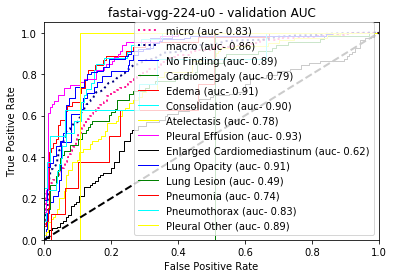

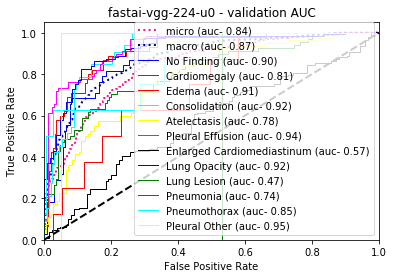

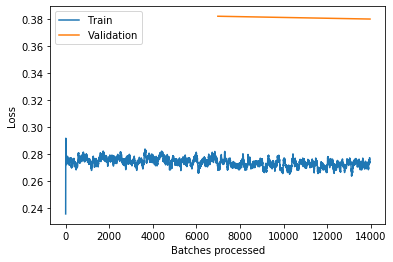

In [12]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3*1e-5,1e-4))
learn.recorder.plot_losses()
learn.save(EXP+'-stage-2')

In [13]:
BS = 32
IMG_SZ = 320
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])
GPU_IDS = [7]
torch.cuda.set_device(7)

EXP = 'fastai-vgg-320-u0'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=valid_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

data

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
No Finding;Support Devices,Lung Opacity;Fracture,Lung Opacity;Fracture,Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Edema;Enlarged Cardiomediastinum;Lung Opacity;Support Devices,Edema;Lung Opacity,No Finding,No Finding,Enlarged Cardiomediastinum
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None

In [15]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png', plot_title='fastai-vgg-320-u0 - validation AUC')])
3# learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load('fastai-vgg-224-u0-stage-2')

Learner(data=DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
No Finding;Support Devices,Lung Opacity;Fracture,Lung Opacity;Fracture,Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Edema;Enlarged Cardiomediastinum;Lung Opacity;Support Devices,Edema;Lung Opacity,No Finding,No Finding,Enlarged Cardiomediastinum
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


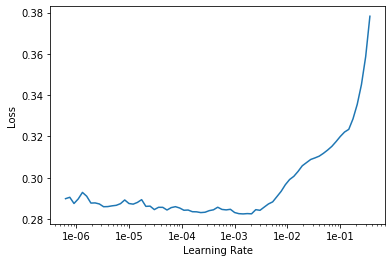

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.278694,0.388506,0.856533,0.809709,0.905820,0.903362,0.757549,0.934579,0.828635,1:00:06
1,0.273531,0.375683,0.863858,0.814316,0.903586,0.917232,0.778896,0.935025,0.844739,59:46


/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc-auc curve saved to results/fastai-vgg-320-u0/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-vgg-320-u0/valid_ROC_AUC.png


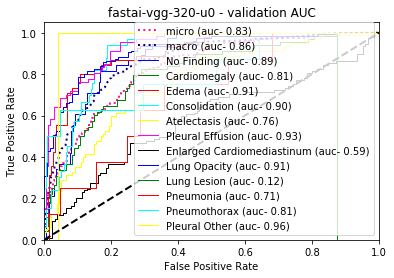

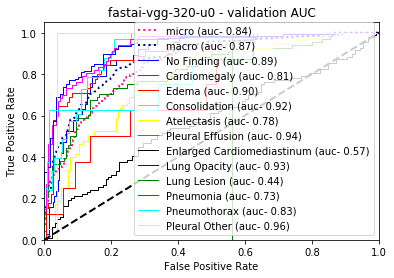

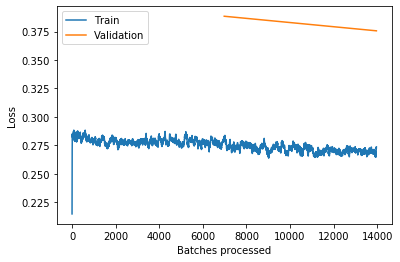

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,3*1e-4))
learn.save(EXP+'-stage-1')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


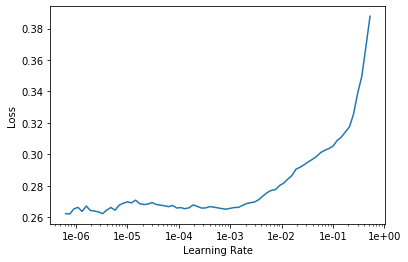

In [18]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,Cardiomegaly-AUC,Edema-AUC,Consolidation-AUC,Atelectasis-AUC,Pleural Effusion-AUC,micro-AUC,time
0,0.264793,0.379343,0.860195,0.807052,0.908054,0.913463,0.793669,0.934936,0.846494,59:48
1,0.263362,0.379422,0.860806,0.818923,0.906408,0.913765,0.785714,0.935204,0.850662,59:45


roc-auc curve saved to results/fastai-vgg-320-u0/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-vgg-320-u0/valid_ROC_AUC.png


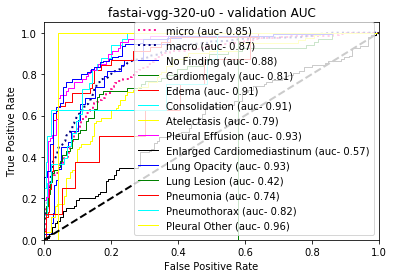

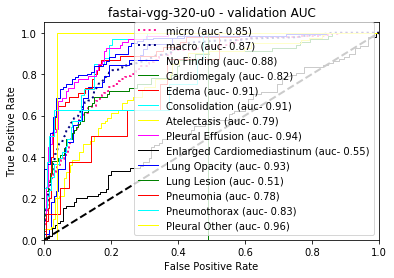

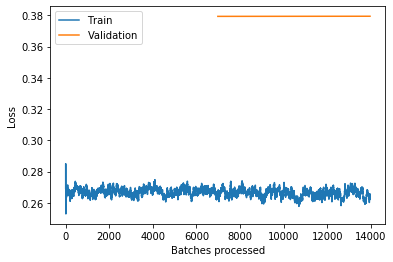

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,3*1e-5))
learn.recorder.plot_losses()
learn.save(EXP+'-stage-2')

In [20]:
learn = cnn_learner(data, models.vgg19_bn, metrics=[acc_02, AUC(pick=1), AUC(pick=2), AUC(pick=3), AUC(pick=4), AUC(pick=5), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')])
learn.load('fastai-vgg-320-u0-stage-2')

Learner(data=DataBunch;

Train: LabelList (223414 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
No Finding;Support Devices,Lung Opacity;Fracture,Lung Opacity;Fracture,Lung Opacity;Fracture,Edema
Path: /home1/amey/CheXpert-v1.0-downsampled;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
Edema;Enlarged Cardiomediastinum;Lung Opacity;Support Devices,Edema;Lung Opacity,No Finding,No Finding,Enlarged Cardiomediastinum
Path: /home1/amey/CheXpert-v1.0-downsampled;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


roc-auc curve saved to results/fastai-vgg-320-u0/valid_ROC_AUC.png


[0.37942156,
 tensor(0.8608),
 0.8189227498228207,
 0.9064079952968842,
 0.9137645107794362,
 0.7857142857142857,
 0.935204218428814,
 0.8506621627406494]

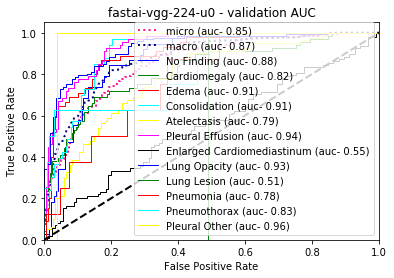

In [21]:
learn.validate(data.valid_dl)

In [22]:
learn.validate??